In [1]:
# Full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# 
from lib_modeling import *
from lib_feature_engineering import *

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

# Load data

- Load train + tvt = train_filtered for features evaluation
- Load train/test for applying mean encoding

In [4]:
# load train/test data
data_path = "home-credit-default-risk/application_train.csv"
pdf_train = pd.read_csv(data_path)

data_path = "home-credit-default-risk/application_test.csv"
pdf_test = pd.read_csv(data_path)

# filter by tvt code
pdf_tvt_extend = pd.read_pickle("pdf_tvt_extend.pkl", compression="bz2")
pdf_train_filtered = (pdf_tvt_extend.query("tvt_code == 'train'")
                      .merge(pdf_train[["SK_ID_CURR"]], on="SK_ID_CURR")
                      .drop(columns=["tvt_code"]))
pdf_train_filtered.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [5]:
# load previous application
data_path = "home-credit-default-risk/installments_payments.csv"
pdf_data = pd.read_csv(data_path)
print(pdf_data.shape)
pdf_data.head()

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [6]:
# load meta data
meta_path = "../02_pandas/reports/report_installments_payments.csv"
pdf_meta = pd.read_csv(meta_path)

# Preprocessing

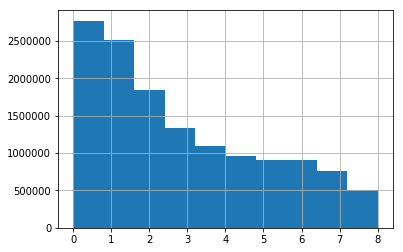

In [7]:
(pdf_data["DAYS_INSTALMENT"] / -365).hist()
plt.show()

In [8]:
# convert to years
pdf_data["DAYS_INSTALMENT_TO_YEARS"] = pdf_data["DAYS_INSTALMENT"] / -365
pdf_data.drop(columns=["DAYS_INSTALMENT"], inplace=True)

In [9]:
# calculate different amount
pdf_data["AMT_PAYMENT"].fillna(0, inplace=True)
pdf_data["diff_amount"] = pdf_data["AMT_PAYMENT"] - pdf_data["AMT_INSTALMENT"]
pdf_data["diff_amount"].describe()

count    1.3605e+07
mean     1.8364e+02
std      1.9125e+04
min     -2.4247e+06
25%      0.0000e+00
50%      0.0000e+00
75%      0.0000e+00
max      2.6309e+06
Name: diff_amount, dtype: float64

## filter data here for looking up balance within years

In [10]:
# pdf_data = pdf_data[(pdf_data["DAYS_INSTALMENT_TO_YEARS"] >= 1) & (pdf_data["DAYS_INSTALMENT_TO_YEARS"] < 2)]
# pdf_data = pdf_data[(pdf_data["DAYS_INSTALMENT_TO_YEARS"] >= 2) & (pdf_data["DAYS_INSTALMENT_TO_YEARS"] < 3)]
# pdf_data = pdf_data[pdf_data["DAYS_INSTALMENT_TO_YEARS"] >= 3]
# print(pdf_data.shape)

# Numerical features

In [11]:
%%time
pdf_agg02 = agg_common_data(pdf_data[["SK_ID_CURR", "NUM_INSTALMENT_NUMBER"]], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")
eval_agg02 = feature_evaluate(pdf_train_filtered, pdf_agg02)
display(eval_agg02)

{'NUM_INSTALMENT_NUMBER': ['max', 'min', 'sum', 'mean', 'std']}

After agg: (339587, 5)


,name,auc,corr,coverage
2,NUM_INSTALMENT_NUMBER_sum,0.5124,-0.0177,1.0000
3,NUM_INSTALMENT_NUMBER_mean,0.5071,-0.0099,1.0000
4,NUM_INSTALMENT_NUMBER_std,0.5049,0.0031,0.9975
0,NUM_INSTALMENT_NUMBER_max,0.5018,0.0044,1.0000
1,NUM_INSTALMENT_NUMBER_min,0.5001,-0.0010,1.0000


CPU times: user 7.51 s, sys: 1.2 s, total: 8.71 s
Wall time: 2.66 s


# Continuous features

In [12]:
# get list continuous attributes
# ls_con = pdf_meta.query("sub_type == 'float64'")["name"].tolist()
series_type = pdf_data.dtypes
ls_con = series_type[series_type == "float64"].index.tolist()
ls_con

['NUM_INSTALMENT_VERSION',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT',
 'DAYS_INSTALMENT_TO_YEARS',
 'diff_amount']

In [13]:
pdf_con = pdf_data[["SK_ID_PREV", "SK_ID_CURR"] + ls_con].copy()
pdf_con.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALMENT_TO_YEARS,diff_amount
0,1054186,161674,1.0,-1187.0,6948.360,6948.360,3.2329,0.000
1,1330831,151639,0.0,-2156.0,1716.525,1716.525,5.9068,0.000
2,2085231,193053,2.0,-63.0,25425.000,25425.000,0.1726,0.000
3,2452527,199697,1.0,-2426.0,24350.130,24350.130,6.6247,0.000
4,2714724,167756,1.0,-1366.0,2165.040,2160.585,3.7890,-4.455


In [14]:
%%time
pdf_agg03 = agg_common_data(pdf_con[["SK_ID_CURR"] + ls_con], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")
eval_agg03 = feature_evaluate(pdf_train_filtered, pdf_agg03)
display(eval_agg03)

{'AMT_INSTALMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_ENTRY_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_INSTALMENT_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'NUM_INSTALMENT_VERSION': ['max', 'min', 'sum', 'mean', 'std'],
 'diff_amount': ['max', 'min', 'sum', 'mean', 'std']}

After agg: (339587, 30)


,name,auc,corr,coverage
1,DAYS_ENTRY_PAYMENT_min,0.5631,0.0597,1.0000
15,DAYS_INSTALMENT_TO_YEARS_max,0.5628,-0.0595,1.0000
19,DAYS_INSTALMENT_TO_YEARS_std,0.5619,-0.0590,0.9975
4,DAYS_ENTRY_PAYMENT_std,0.5610,-0.0585,0.9974
3,DAYS_ENTRY_PAYMENT_mean,0.5560,0.0447,1.0000
6,AMT_PAYMENT_min,0.5554,-0.0244,1.0000
18,DAYS_INSTALMENT_TO_YEARS_mean,0.5553,-0.0442,1.0000
13,diff_amount_mean,0.5552,-0.0306,1.0000
2,DAYS_ENTRY_PAYMENT_sum,0.5496,0.0352,1.0000
17,DAYS_INSTALMENT_TO_YEARS_sum,0.5492,-0.0350,1.0000


CPU times: user 20.7 s, sys: 864 ms, total: 21.6 s
Wall time: 7.93 s


# Save features

In [15]:
pdf_feat = pdf_agg02.join(pdf_agg03)
print(pdf_feat.shape)

(339587, 35)


In [16]:
%%time
fname = "installments_payments"
# fname = "installments_payments_in1year"
# fname = "installments_payments_in2year"
# fname = "installments_payments_gt3year"

fname = os.path.join("features", "{}.pkl.bz2".format(fname))
pdf_feat.to_pickle(fname, compression="bz2")
print("Store features completed!")

Store features completed!
CPU times: user 8.74 s, sys: 160 ms, total: 8.9 s
Wall time: 7.55 s
